# 데이터 로드, 데이터 확인
* ### 본문(text)과 요약문(headlines) 데이터만 추출
* ### 결측값 제거, 누락된 데이터 삭제

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

# CSV 파일 로드
file_path = 'news_summary_more.csv'  # 파일 경로를 실제 위치로 변경
data = pd.read_csv(file_path)

# 필요한 컬럼만 선택 (text와 headlines)
data = data[['text', 'headlines']]

# 결측값 제거
data = data.dropna()

# 데이터 확인
print(f"전체 데이터 샘플 수: {len(data)}")
data.head()

전체 데이터 샘플 수: 98401


,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


# 데이터 전처리
* ### 뉴스 기사에 포함된 HTML 태그 및 특수 문자 제거
* ### 소문자 변환, 일관되게 처리 

In [2]:
# 텍스트 정제 함수 정의
def clean_text(text):
    """
    텍스트 데이터를 정제하여 반환합니다.
    - HTML 태그 제거
    - 괄호, 특수문자 제거
    - 소문자로 변환
    """
    text = re.sub(r'<[^>]+>', '', text)  # HTML 태그 제거
    text = re.sub(r'\([^)]*\)', '', text)  # 괄호 제거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 알파벳, 숫자, 공백 이외 문자 제거
    text = text.lower()  # 소문자로 변환
    return text

# 본문과 요약문 정제
data['text'] = data['text'].apply(clean_text)
data['headlines'] = data['headlines'].apply(clean_text)

# 데이터 확인
print(f"정제된 데이터 샘플 수: {len(data)}")
data.head()

정제된 데이터 샘플 수: 98401


,text,headlines
0,saurav kant an alumnus of upgrad and iiitbs pg...,upgrad learner switches to career in ml al wi...
1,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india by 8 wickets in the...,new zealand end rohit sharmaled indias 12match...
3,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan helps customer...
4,speaking about the sexual harassment allegatio...,have known hirani for yrs what if metoo claims...


# 데이터 분할, 토큰화 진행
* ### 토큰회, 단어를 정수 인덱스로 변환하여 딥러닝 모델이 처리 가능한 형태로 변화
* ### 패딩, 시퀸스 길이를 동일하게 맞춰 모델 입력에 적합하도록 처리 

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 학습 및 테스트 데이터 분할 (8:2 비율)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 토크나이저 정의
text_tokenizer = Tokenizer(num_words=15000)  # 상위 15,000개 단어만 사용
text_tokenizer.fit_on_texts(train_data['text'])

summary_tokenizer = Tokenizer(num_words=5000)  # 상위 5,000개 단어만 사용
summary_tokenizer.fit_on_texts(train_data['headlines'])

# 정수 인덱스 시퀀스로 변환
train_text_seq = text_tokenizer.texts_to_sequences(train_data['text'])
train_summary_seq = summary_tokenizer.texts_to_sequences(train_data['headlines'])
test_text_seq = text_tokenizer.texts_to_sequences(test_data['text'])
test_summary_seq = summary_tokenizer.texts_to_sequences(test_data['headlines'])

# 패딩 추가
max_text_len = 100  # 본문 최대 길이
max_summary_len = 15  # 요약문 최대 길이
train_text_seq = pad_sequences(train_text_seq, maxlen=max_text_len, padding='post')
train_summary_seq = pad_sequences(train_summary_seq, maxlen=max_summary_len, padding='post')
test_text_seq = pad_sequences(test_text_seq, maxlen=max_text_len, padding='post')
test_summary_seq = pad_sequences(test_summary_seq, maxlen=max_summary_len, padding='post')

# 모델 설계(어텐션 메커니즘)
* ### 어텐션 메커니즘, 인코더 출력과 디코더 상태를 조합하여 중요한 정보를 선택적으로 참조 
* ### 디코더 설계 decoder_inputs 부분에서 에러 발생, 종료 토큰을 제외, -1로 설정하여 해결 

In [7]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# 설정값
embedding_dim = 128
hidden_size = 128
src_vocab = len(text_tokenizer.word_index) + 1
tar_vocab = len(summary_tokenizer.word_index) + 1

# 인코더 설계
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더 설계
decoder_inputs = Input(shape=(max_summary_len - 1,))
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘
attention = Attention()([decoder_outputs, encoder_outputs])
concat_outputs = Concatenate(axis=-1)([decoder_outputs, attention])

# 출력층
decoder_dense = Dense(tar_vocab, activation='softmax')
outputs = decoder_dense(concat_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 128)     13182592    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 14, 128)      5055872     input_4[0][0]                    
____________________________________________________________________________________________

# 모델 학습, 저장
* ### 디코더 입력, 출력 데이터 길이를 명확히 구분
* ### 학습이 개선되지 않을 때 학습을 조기 종료, 과적합 방지
* ### 결과 시각화

Epoch 1/50
615/615 [==============================] - 46s 67ms/step - loss: 3.8000 - val_loss: 3.5277
Epoch 2/50
615/615 [==============================] - 42s 68ms/step - loss: 3.4585 - val_loss: 3.3343
Epoch 3/50
615/615 [==============================] - 43s 69ms/step - loss: 3.2761 - val_loss: 3.1733
Epoch 4/50
615/615 [==============================] - 42s 69ms/step - loss: 3.1303 - val_loss: 3.0586
Epoch 5/50
615/615 [==============================] - 42s 69ms/step - loss: 3.0139 - val_loss: 2.9674
Epoch 6/50
615/615 [==============================] - 42s 69ms/step - loss: 2.9195 - val_loss: 2.8989
Epoch 7/50
615/615 [==============================] - 42s 69ms/step - loss: 2.8353 - val_loss: 2.8304
Epoch 8/50
615/615 [==============================] - 42s 69ms/step - loss: 2.7611 - val_loss: 2.7736
Epoch 9/50
615/615 [==============================] - 42s 69ms/step - loss: 2.6943 - val_loss: 2.7204
Epoch 10/50
615/615 [==============================] - 42s 69ms/step - loss: 2.634

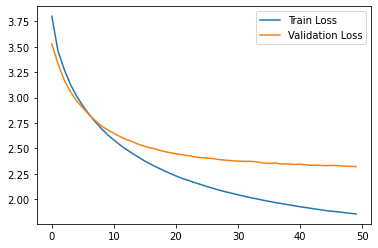

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 조기 종료 설정
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 디코더 입력과 출력 데이터 재정의
decoder_input_data = train_summary_seq[:, :-1]  # 디코더 입력은 마지막 토큰 제외
decoder_output_data = train_summary_seq[:, 1:]  # 디코더 출력은 첫 번째 토큰 제외 (<sostoken> 제거)

# 출력 데이터의 마지막 차원을 확장하여 sparse_categorical_crossentropy에 적합하게 변경
decoder_output_data = decoder_output_data.reshape(decoder_output_data.shape[0], decoder_output_data.shape[1], 1)

# 검증 데이터도 동일하게 처리
val_decoder_input_data = test_summary_seq[:, :-1]
val_decoder_output_data = test_summary_seq[:, 1:]
val_decoder_output_data = val_decoder_output_data.reshape(val_decoder_output_data.shape[0], val_decoder_output_data.shape[1], 1)

# 모델 학습
history = model.fit(
    [train_text_seq, decoder_input_data],
    decoder_output_data,
    epochs=50,
    batch_size=128,
    validation_data=(
        [test_text_seq, val_decoder_input_data],
        val_decoder_output_data
    ),
    callbacks=[es]
)

# 학습 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 모델 저장
model.save('news_summary_model.keras')

# 회고
## 신상호 
* ### 토큰 활용과 모델에 사용하는 부분이 많이 낮설었습니다. 몇 가지 부분에서 에러가 발생했었는데<br> GPT의 조언, 개선 제안을 반영하여 해결할 수 있었고 최종적으로 코드를 완성할 수 있었습니다. 